In [ ]:
import numpy as np
np.random.seed(123)
import pandas as pd
import pandas.testing as tm
import pandas.util.testing as tm
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import linear_model
from sklearn import metrics
from sklearn.svm import SVR
import json

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  """


In [ ]:
# loading the train and test dataset
df_1=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Case Study 1/mercedes-benz-greener-manufacturing/train.csv/train.csv')
df_2=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Case Study 1/mercedes-benz-greener-manufacturing/test.csv/test.csv')

In [ ]:
print(df_1.shape)
print(df_2.shape)

(4209, 378)
(4209, 377)


In [ ]:
missing_cols = set( df_1.columns ) - set( df_2.columns )
missing_cols

{'y'}

In [ ]:
# converting categorical features to numerical features
x_dummies_1=pd.get_dummies(df_1)
x_dummies_1.head()
x_dummies_2=pd.get_dummies(df_2) 
x_dummies_2.head()
#https://pandas.pydata.org/pandas-docs/version/0.21.1/generated/pandas.get_dummies.html
#https://towardsdatascience.com/encoding-categorical-features-21a2651a065c

,ID,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,...,X5_x,X5_y,X5_z,X6_a,X6_b,X6_c,X6_d,X6_e,X6_f,X6_g,X6_h,X6_i,X6_j,X6_k,X6_l,X8_a,X8_b,X8_c,X8_d,X8_e,X8_f,X8_g,X8_h,X8_i,X8_j,X8_k,X8_l,X8_m,X8_n,X8_o,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(x_dummies_1.shape)
print(x_dummies_2.shape)

(4209, 565)
(4209, 570)


In [ ]:
missing_cols = set( x_dummies_1.columns ) - set( x_dummies_2.columns )
missing_cols 

In [ ]:
missing_cols

{'X0_aa',
 'X0_ab',
 'X0_ac',
 'X0_q',
 'X2_aa',
 'X2_ar',
 'X2_c',
 'X2_l',
 'X2_o',
 'X5_u',
 'y'}

In [ ]:
y=x_dummies_1['y']

In [ ]:
# align dataframes 
x_dummies_1, x_dummies_2= x_dummies_1.align(x_dummies_2, join='inner', axis=1)

In [ ]:
print(x_dummies_1.shape)
print(x_dummies_2.shape)

(4209, 554)
(4209, 554)


In [ ]:
missing_cols = set( x_dummies_1.columns ) - set( x_dummies_2.columns )

In [ ]:
missing_cols

set()

# 1: Dropping Unique values

In [ ]:
# creating a list of columns which have only zeros
zeros=[]
for i,j in x_dummies_1.any().items():#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.iteritems.html
    if j==False:
        zeros.append(i)

In [ ]:
zeros # 'X339' is missing in my code
# we need to drop these columns

['X11',
 'X93',
 'X107',
 'X233',
 'X235',
 'X268',
 'X289',
 'X290',
 'X293',
 'X297',
 'X330',
 'X347']

In [ ]:
x_1_safe = x_dummies_1
x_2_safe = x_dummies_2 

In [ ]:
x_dummies_1 = x_dummies_1.drop(zeros, axis=1)
x_dummies_2 = x_dummies_2.drop(zeros, axis=1)

In [ ]:
print(x_2_safe.shape)
x_2_safe = x_2_safe.drop(zeros, axis=1)
print(x_2_safe.shape)

(4209, 554)
(4209, 542)


In [ ]:
x_dummies_1['y']=y 

# 2: Dropping Outliers

In [ ]:
x_filtered= x_dummies_1[x_dummies_1['y']>70]#https://www.geeksforgeeks.org/drop-rows-from-the-dataframe-based-on-certain-condition-applied-on-a-column/
x_filtered= x_filtered[x_filtered['y']<150]
x_filtered.describe()

,ID,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,...,X5_x,X5_y,X6_a,X6_b,X6_c,X6_d,X6_e,X6_f,X6_g,X6_h,X6_i,X6_j,X6_k,X6_l,X8_a,X8_b,X8_c,X8_d,X8_e,X8_f,X8_g,X8_h,X8_i,X8_j,X8_k,X8_l,X8_m,X8_n,X8_o,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y,y
count,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,...,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.00000,4194.000000,4194.000000,4194.00000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000
mean,4209.773724,0.013352,0.074392,0.057940,0.428231,0.000477,0.002623,0.007630,0.007868,0.099666,0.142823,0.002623,0.086791,0.020744,0.001907,0.005007,0.682165,0.032666,0.043157,0.004530,0.231998,0.011206,0.000238,0.005484,0.231998,0.004530,0.231998,0.033381,0.000238,0.000715,0.011445,0.000238,0.072246,0.011445,0.253219,0.597282,0.012876,0.022413,0.122556,0.214592,...,0.000477,0.000238,0.049118,0.006676,0.008822,0.148546,0.002861,0.004769,0.24702,0.045303,0.116357,0.24702,0.010014,0.113495,0.049833,0.045303,0.023844,0.024082,0.053410,0.057940,0.030758,0.027897,0.056509,0.065808,0.041965,0.024082,0.036719,0.057701,0.038865,0.023605,0.027659,0.051741,0.060563,0.028135,0.028374,0.046257,0.046495,0.024797,0.027659,100.439938
std,2437.897217,0.114792,0.262439,0.233658,0.494881,0.021835,0.051152,0.087026,0.088365,0.299590,0.349934,0.051152,0.281562,0.142543,0.043638,0.070592,0.465690,0.177781,0.203234,0.067163,0.422158,0.105278,0.015441,0.073860,0.422158,0.067163,0.422158,0.179651,0.015441,0.026739,0.106380,0.015441,0.258926,0.106380,0.434907,0.490503,0.112751,0.148040,0.327966,0.410588,...,0.021835,0.015441,0.216140,0.081445,0.093522,0.355682,0.053420,0.068899,0.43133,0.207992,0.320690,0.43133,0.099581,0.317235,0.217626,0.207992,0.152580,0.153322,0.224876,0.233658,0.172683,0.164697,0.230930,0.247976,0.200532,0.153322,0.188094,0.233206,0.193296,0.151834,0.164012,0.221529,0.238555,0.165379,0.166058,0.210065,0.210580,0.155526,0.164012,11.994753
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,72.110000
25%,2096.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000

In [ ]:
print(type(x_filtered))
print(x_filtered.shape)
print(type(x_dummies_2))
print(x_dummies_2.shape)

<class 'pandas.core.frame.DataFrame'>
(4194, 543)
<class 'pandas.core.frame.DataFrame'>
(4209, 542)


In [ ]:
print(x_filtered.shape)
y=x_filtered['y']
x_filtered=x_filtered.drop(['y'], axis=1)
print(x_filtered.shape, y.shape)
print(type(x_filtered), type(y))

(4194, 543)
(4194, 542) (4194,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [ ]:
top_20_features= ['ID', 'X14', 'X29', 'X54', 'X76', 'X118', 'X119', 'X127', 'X132',
       'X136', 'X189', 'X222', 'X232', 'X263', 'X279', 'X311', 'X314', 'X315',
       'X6_g', 'X6_j']
type(top_20_features)

list

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/Case Study 1/inf_indices_complete.txt', 'r') as f:
    checc=json.loads(f.read())


In [ ]:
inf_indices=checc

In [ ]:
print(x_filtered.shape)
x_filtered = x_filtered.drop(inf_indices, axis=1)
x_dummies_2= x_dummies_2.drop(inf_indices, axis=1)
print(x_filtered.shape)
print(x_dummies_2.shape)

(4194, 542)
(4194, 121)
(4209, 121)


4: Adding new features using dimensionality reduction techniques

In [ ]:
from sklearn.decomposition import Truncate dSVD
tsvd= TruncatedSVD(n_components=2, random_state=42) 
tsvd_train= tsvd.fit_transform(x_filtered)
tsvd_test=  tsvd.transform(x_dummies_2) 

In [ ]:
tsvd_train.shape

(4194, 2)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
pca_train= pca.fit_transform(x_filtered)
pca_test= pca.transform(x_dummies_2)

In [ ]:
pca_train.shape

(4194, 2)

In [ ]:
from sklearn.decomposition import FastICA
ica=FastICA(n_components=2, random_state=42)
ica_train= ica.fit_transform(x_filtered)
ica_test= ica.transform(x_dummies_2)

In [ ]:
ica_train.shape

(4194, 2)

In [ ]:
for i in range(0, tsvd_train.shape[1]):
    x_filtered['tsvd_'+str(i)]= tsvd_train[:, i]
    x_dummies_2['tsvd_'+str(i)]= tsvd_test[:, i]
    x_filtered['pca_'+str(i)]= pca_train[:, i]
    x_dummies_2['pca_'+str(i)]= pca_test[:, i]
    x_filtered['ica_'+str(i)]= ica_train[:, i]
    x_dummies_2['ica_'+str(i)]= ica_test[:, i]

In [ ]:
print(x_filtered.shape, x_dummies_2.shape)

(4194, 127) (4209, 127)


# 3: Adding new features using the top important features

In [ ]:
x_filtered['X64 + X218']=x_filtered['X64']+x_filtered['X218']
x_dummies_2['X64 + X218']=x_dummies_2['X64']+x_dummies_2['X218']

x_filtered['X218 + X224 + X273']=x_filtered['X218']+x_filtered['X224'] + x_filtered['X273']
x_dummies_2['X218 + X224 + X273']=x_dummies_2['X218']+x_dummies_2['X224'] + x_dummies_2['X273']

x_filtered['X64 + X224 + X273']=x_filtered['X64']+x_filtered['X224'] + x_filtered['X273']
x_dummies_2['X64 + X224 + X273']=x_dummies_2['X64']+x_dummies_2['X224'] + x_dummies_2['X273']



In [ ]:
x_filtered['X314 + X315']=x_filtered['X314']+x_filtered['X315']
x_dummies_2['X314 + X315']=x_dummies_2['X314']+x_dummies_2['X315']

x_filtered['X314 + X315 + X29']=x_filtered['X314']+x_filtered['X315'] + x_filtered['X29']
x_dummies_2['X314 + X315 + X29']=x_dummies_2['X314']+x_dummies_2['X315'] + x_dummies_2['X29']

x_filtered['X314 + X315 + X118']=x_filtered['X314']+x_filtered['X315'] + x_filtered['X118']
x_dummies_2['X314 + X315 + X118']=x_dummies_2['X314']+x_dummies_2['X315'] + x_dummies_2['X118']

x_filtered['X127 + X189']=x_filtered['X127']+x_filtered['X189']
x_dummies_2['X127 + X189']=x_dummies_2['X127']+x_dummies_2['X189']

x_filtered['X118 + X54']=x_filtered['X118']+x_filtered['X54']
x_dummies_2['X118 + X54']=x_dummies_2['X118']+x_dummies_2['X54']


In [ ]:
# for adaboost splitting x_filtered
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x_filtered, y, test_size=0.2, random_state=42)

# : ==========================================




#  4: RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in a Random forest
n_estimators=[int(x) for x in np.linspace (start=100, stop=1000, num=10)]

# Number of features to consider at every split
max_features=['auto', 'sqrt']

# Maximun no of levels in a tree
max_depth=[int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# minimum number of samples required to split a node
min_samples_split = np.arange(50,250,20)

# Minimum number of samples required at each leaf node
min_samples_leaf = np.arange(5,50,5)
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': array([ 50,  70,  90, 110, 130, 150, 170, 190, 210, 230]), 'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45]), 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model 
rf_random.fit(x_filtered, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 28.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
rf_random.best_params_ 

{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 40,
 'min_samples_split': 110,
 'n_estimators': 500}

In [ ]:
best_rf=rf_random.best_estimator_
best_rf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=70, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=40,
                      min_samples_split=110, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
#temp
best_rf= RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=70, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=40,
                      min_samples_split=110, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# fitting the best model on to the dataset
best_rf.fit(x_filtered, y)
y_train_pred=best_rf.predict(x_filtered)
y_test_pred=best_rf.predict(x_dummies_2)

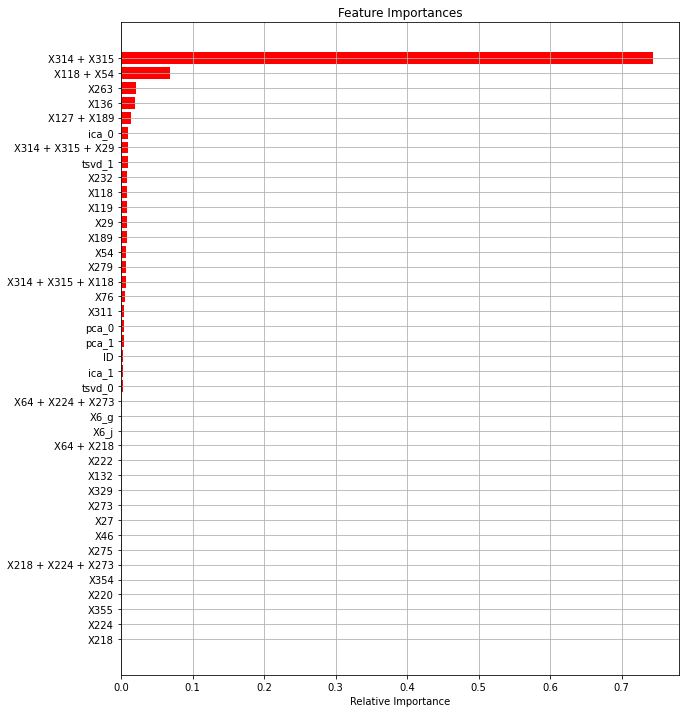

In [ ]:
features = x_filtered.columns
importances = best_rf.feature_importances_
indices = (np.argsort(importances))[-40:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.show()

In [ ]:
# checking r2 score
from sklearn.metrics import r2_score
print('train r2_score', r2_score(y, y_train_pred))
print('='*30)
#print('test r2_score', r2_score(y_test, y_test_pred))

train r2_score 0.6535470835738704


In [ ]:
final_df= pd.DataFrame(list(zip(df_2['ID'].values, y_test_pred)), columns=['ID', 'y'])

In [ ]:
final_df.head()

,ID,y
0,1,78.434875
1,2,94.254870
2,3,78.439658
3,4,78.434875
4,5,113.514419


In [ ]:
final_df.to_csv(r'/content/drive/My Drive/Colab Notebooks/Case Study 1/RandomForestRegressor_1.csv',index=False)

# 5: XGBoostRegressor

In [ ]:
import xgboost as xgb

In [ ]:
xgb_model=xgb.XGBRegressor()
#xgb_model.fit(x_train, y_train)
#y_pred=xgb_model.predict(x_train)
learning_rate=[0.001, 0.01, 0.1, 0.2, 0.3]
n_estimators=[50, 100, 150, 200, 250, 300]
hyperparameters= dict(learning_rate=learning_rate, n_estimators=n_estimators)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rsearch = RandomizedSearchCV(xgb_model, hyperparameters, n_iter=10, random_state=41)
rsearch.fit(x_filtered, y)


In [ ]:
print(rsearch.best_params_)

{'n_estimators': 300, 'learning_rate': 0.01}


In [ ]:
# custom implementation of finding optimal hyperparameters has been deleted 

In [ ]:
best_xgb=rsearch.best_estimator_
best_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
# fitting the best model on to the dataset
best_xgb.fit(x_filtered, y)
y_train_pred=best_xgb.predict(x_filtered)
y_test_pred=best_xgb.predict(x_dummies_2)

[10:01:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


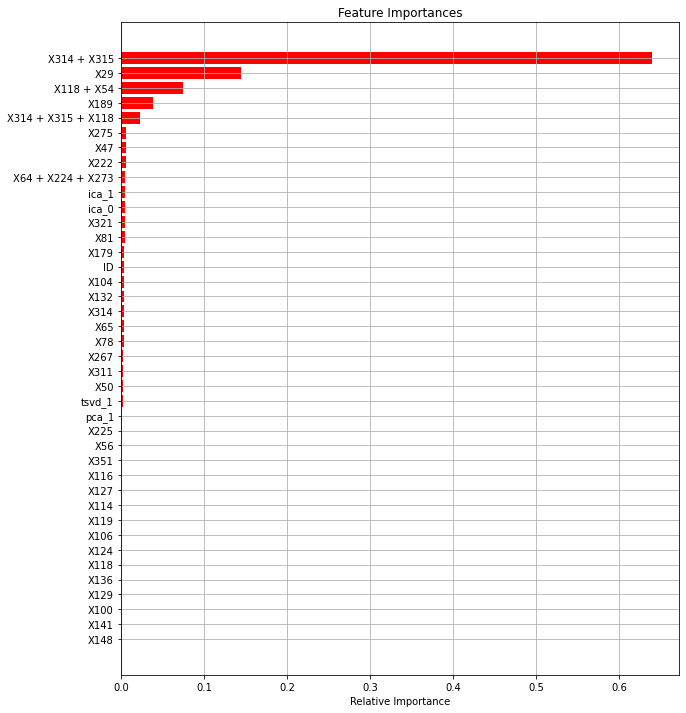

In [ ]:
import matplotlib.pyplot as plt
features = x_filtered.columns
importances = best_xgb.feature_importances_
indices = (np.argsort(importances))[-40:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.show()

In [ ]:
# checking r2 score
from sklearn.metrics import r2_score
print('train r2_score', r2_score(y, y_train_pred))
print('='*30)
#print('test r2_score', r2_score(y_test, y_test_pred))

train r2_score 0.4664656045758411


In [ ]:
final_df_1= pd.DataFrame(list(zip(df_2['ID'].values, y_test_pred)), columns=['ID', 'y'])

In [ ]:
final_df_1.head()

,ID,y
0,1,77.488136
1,2,93.120033
2,3,75.105789
3,4,75.105789
4,5,106.988533


In [ ]:
final_df_1.to_csv(r'/content/drive/My Drive/Colab Notebooks/Case Study 1/XGBoostRegressor_1.csv',index=False)

# 6: DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt_model=DecisionTreeRegressor()
dt_model

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
max_depth=[1, 5, 10, 50]
min_samples_split=[5, 10, 100, 500]
hyperparameters= dict(max_depth=max_depth, min_samples_split=min_samples_split)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rsearch = RandomizedSearchCV(dt_model, hyperparameters, n_iter=10, random_state=41)
rsearch.fit(x_filtered, y)
print(rsearch.best_params_)

{'min_samples_split': 500, 'max_depth': 5}


In [ ]:
rsearch.best_params_

{'max_depth': 5, 'min_samples_split': 500}

In [ ]:
best_dt=rsearch.best_estimator_
best_dt

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=500,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
# fitting the best model on to the dataset
best_dt.fit(x_filtered, y)
y_train_pred=best_dt.predict(x_filtered)
y_test_pred=best_dt.predict(x_dummies_2)

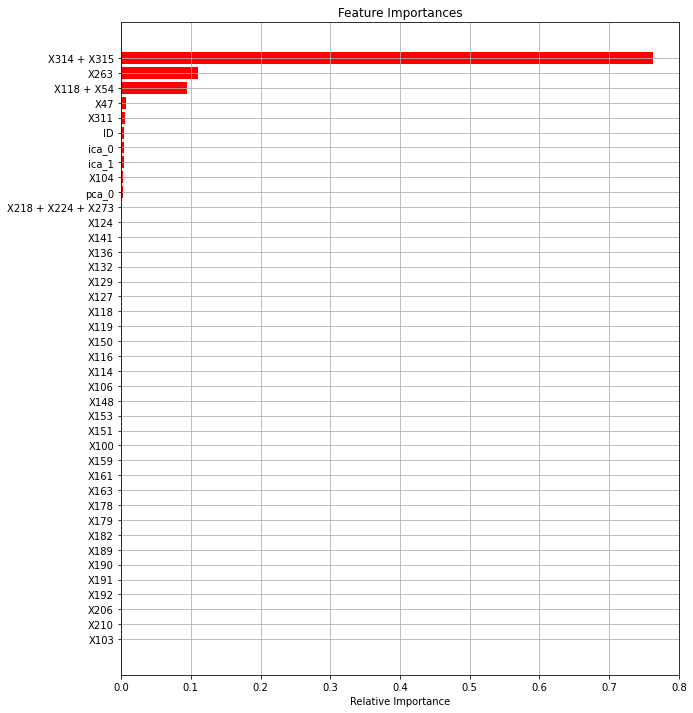

In [ ]:
import matplotlib.pyplot as plt
features = x_filtered.columns
importances = best_dt.feature_importances_
indices = (np.argsort(importances))[-40:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.show()

In [ ]:
# checking r2 score
from sklearn.metrics import r2_score
print('train r2_score', r2_score(y, y_train_pred))
print('='*30)
#print('test r2_score', r2_score(y_test, y_test_pred))

train r2_score 0.641140515826669


In [ ]:
final_df_2= pd.DataFrame(list(zip(df_2['ID'].values, y_test_pred)), columns=['ID', 'y'])

In [ ]:
final_df_2.head()

,ID,y
0,1,77.964862
1,2,130.810000
2,3,77.964862
3,4,77.964862
4,5,112.866875


In [ ]:
final_df_2.to_csv(r'/content/drive/My Drive/Colab Notebooks/Case Study 1/DecisionTreeRegressor_1.csv',index=False)

# 7: Ridge Regressor

In [ ]:
from sklearn.linear_model import Ridge
ridge_regressor= Ridge()
ridge_regressor

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
parameters= {'alpha': [10,20,  50, 100, 150, 200, 250, 300]}
ridge_grid_scv= GridSearchCV(ridge_regressor, parameters, scoring='r2', cv=5)
ridge_grid_scv.fit(x_filtered, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [10, 20, 50, 100, 150, 200, 250, 300]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [ ]:
print(ridge_grid_scv.best_params_)
print(ridge_grid_scv.best_score_)

{'alpha': 20}
0.6018030809140671


In [ ]:
ridge_regressor= Ridge(alpha=20)
ridge_regressor

Ridge(alpha=20, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [ ]:
ridge_regressor.fit(x_filtered, y)
y_train_pred=ridge_regressor.predict(x_filtered)
y_test_pred =ridge_regressor.predict(x_dummies_2)

In [ ]:
# checking r2 score
from sklearn.metrics import r2_score
print('train r2_score', r2_score(y, y_train_pred))
print('='*30)
#print('test r2_score', r2_score(y_test, y_test_pred))

train r2_score 0.6247618099854948


In [ ]:
final_df_4= pd.DataFrame(list(zip(df_2['ID'].values, y_test_pred)), columns=['ID', 'y'])

In [ ]:
final_df_4.head()

,ID,y
0,1,79.891570
1,2,96.265184
2,3,80.607815
3,4,78.035424
4,5,110.400392


In [ ]:
final_df_4.to_csv(r'/content/drive/My Drive/Colab Notebooks/Case Study 1/RidgeRegressor_1.csv',index=False)

# 8: Lasso Regressor

In [ ]:
lasso= Lasso()
lasso

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
parameters= {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
lasso_grid_scv= GridSearchCV(lasso, parameters, scoring='r2', cv=5)
lasso_grid_scv.fit(x_filtered, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [ ]:
print(lasso_grid_scv.best_params_)
print(lasso_grid_scv.best_score_)

{'alpha': 0.01}
0.6031800961153089


In [ ]:
lasso_regressor= Lasso(alpha=0.01)
lasso_regressor

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
#https://towardsdatascience.com/how-to-perform-lasso-and-ridge-regression-in-python-3b3b75541ad8
#https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/
#https://alfurka.github.io/2018-11-18-grid-search/
lasso_regressor.fit(x_filtered, y)
y_train_pred=lasso_regressor.predict(x_filtered)
y_test_pred =lasso_regressor.predict(x_dummies_2) b 

In [ ]:
# checking r2 score
from sklearn.metrics import r2_score
print('train r2_score', r2_score(y, y_train_pred))
print('='*30)
#print('test r2_score', r2_score(y_test, y_test_pred))

train r2_score 0.6234275817168167


In [ ]:
final_df_5= pd.DataFrame(list(zip(df_2['ID'].values, y_test_pred)), columns=['ID', 'y'])

In [ ]:
final_df_5.head()

,ID,y
0,1,79.534046
1,2,96.370153
2,3,80.228208
3,4,77.973903
4,5,111.042708


In [ ]:
final_df_5.to_csv(r'/content/drive/My Drive/Colab Notebooks/Case Study 1/LassoRegressor_1.csv',index=False)

# 9: AdaBoostRegressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
abr= AdaBoostRegressor()
abr 

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [ ]:
from tqdm import tqdm_notebook
from sklearn.metrics import r2_score
train_r2=[]
cv_r2=[] 
dict_cv_r2={}
max_depth = [10, 11, 12, 13, 14, 15]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1]
n_estimators = [50, 100, 150, 200, 250, 300] 
min_samples_split=[5, 10, 100, 500]
for i in tqdm_notebook(learning_rate):
    for j in tqdm_notebook(n_estimators):
        for p in tqdm_notebook(max_depth):
            for q in tqdm_notebook(min_samples_split):
                abr= AdaBoostRegressor(base_estimator= DecisionTreeRegressor(max_depth=p, min_samples_split=q), learning_rate=i, n_estimators=j)
                abr.fit(x_train,y_train)
                y_cap_train=abr.predict(x_train)
                y_cap_cv=abr.predict(x_test)
                train_r2.append(r2_score(y_train,y_cap_train))
                k=r2_score(y_test,y_cap_cv)
                dict_cv_r2[k]=i,j,p,q
                cv_r2.append(r2_score(y_test,y_cap_cv)) 
maximum_auc_score=max(cv_r2)

In [1]:
print(maximum_auc_score)

0.6595712090316805

In [ ]:
print(dict_cv_r2)
dict_cv_r2[maximum_auc_score]

{0.6511007133167936: (0.0001, 50, 10, 5), 0.6428779700880041: (0.0001, 50, 10, 10), 0.6578170919843221: (0.0001, 50, 10, 100), 0.6557549175059931: (0.0001, 50, 10, 500), 0.6517144099052639: (0.0001, 50, 11, 5), 0.6483374631981604: (0.0001, 50, 11, 10), 0.6565804378601887: (0.0001, 50, 11, 100), 0.656691849759546: (0.0001, 50, 11, 500), 0.646600570315921: (0.0001, 50, 12, 5), 0.6478431171467417: (0.0001, 50, 12, 10), 0.6585834651588822: (0.0001, 50, 12, 100), 0.6520587876646939: (0.0001, 50, 12, 500), 0.6447626922911105: (0.0001, 50, 13, 5), 0.6476516726365565: (0.0001, 50, 13, 10), 0.6586544255534148: (0.0001, 50, 13, 100), 0.6595712090316805: (0.0001, 50, 13, 500), 0.647285178465411: (0.0001, 50, 14, 5), 0.6415739427063019: (0.0001, 50, 14, 10), 0.6543003684018358: (0.0001, 50, 14, 100), 0.6545553168936121: (0.0001, 50, 14, 500), 0.6360585511638239: (0.0001, 50, 15, 5), 0.6426813722267957: (0.0001, 50, 15, 10), 0.654452340144759: (0.0001, 50, 15, 100), 0.6575684881344157: (0.0001, 50,

(0.0001, 50, 13, 500)

In [ ]:
print(maximum_auc_score, dict_cv_r2[maximum_auc_score])
print(i,j,p,q)

0.6595712090316805 (0.0001, 50, 13, 500)


In [ ]:
'''#https://machinelearningmastery.com/adaboost-ensemble-in-python/
gsearch = GridSearchCV(abr, parameters, scoring='r2')
gsearch.parameters = {'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1], 'n_estimators' : [50, 100, 150, 200, 250, 300], 'base_estimator':[DecisionTreeRegressor(), RandomForestRegressor()]}
fit(x_filtered, y) '''

In [ ]:
'''print(gsearch.best_estimator_)
print(gsearch.best_score_)'''

In [ ]:
abr= AdaBoostRegressor(base_estimator= DecisionTreeRegressor(max_depth=13, min_samples_split=500), learning_rate=0.0001, loss='linear',  n_estimators=50)
abr

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=13,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=500,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
               

In [ ]:
abr.fit(x_filtered, y)
y_train_pred=abr.predict(x_filtered)
y_test_pred =abr.predict(x_dummies_2)

In [ ]:
# checking r2 score
from sklearn.metrics import r2_score
print('train r2_score', r2_score(y, y_train_pred))
print('='*30)
#print('test r2_score', r2_score(y_test, y_test_pred))

train r2_score 0.6548302212556886


In [ ]:
final_df_10= pd.DataFrame(list(zip(df_2['ID'].values, y_test_pred)), columns=['ID', 'y'])

In [ ]:
final_df_10.head()

,ID,y
0,1,77.976183
1,2,120.827500
2,3,77.976183
3,4,77.976183
4,5,114.540885


In [ ]:
final_df_10.to_csv(r'/content/drive/My Drive/Colab Notebooks/Case Study 1/CSV files/AdaBoostRegressor_2.csv',index=False)